# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт модулей

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# загружаем данные

try:
    data = pd.read_csv('practicum\autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
# приводим названия к нижнему регистру

data.columns = data.columns.str.lower()

In [8]:
# переименовывем колонки после приведения к единому регистру
data = data.rename(columns={'datecrawled': 'crawled', 
                            'vehicletype': 'vehicle', 
                            'registrationyear': 'registration_year', 
                            'registrationmonth': 'registration_month', 
                            'fueltype': 'fuel', 
                            'datecreated': 'created_date', 
                            'numberofpictures': 'num_of_pics', 
                            'postalcode': 'postal_code', 
                            'lastseen': 'last_seen'})

### Описание данных

__Признаки :__  

__crawled__ — дата скачивания анкеты из базы  
__vehicle__ — тип автомобильного кузова  
__registration_year__ — год регистрации автомобиля  
__gearbox__ — тип коробки передач  
__power__ — мощность (л. с.)  
__model__ — модель автомобиля  
__kilometer__ — пробег (км)  
__registration_month__ — месяц регистрации автомобиля  
__fuel__ — тип топлива  
__brand__ — марка автомобиля  
__repaired__ — была машина в ремонте или нет  
__created_date__ — дата создания анкеты  
__num_of_pics__ — количество фотографий автомобиля  
__postal_code__ — почтовый индекс владельца анкеты (пользователя)  
__last_seen__ — дата последней активности пользователя

__Целевой признак :__

__price__ — цена (евро)

__Работаем с датой__

In [9]:
data['created_date'] = pd.to_datetime(data['created_date']).dt.year
data.loc[data['registration_year'] > data['created_date'], 'registration_year'] = data['created_date']

Удоляем лишние данные которые точно не влияют на целевой признак

In [10]:
data.drop(columns=['crawled', 'created_date', 'num_of_pics','postal_code','last_seen','registration_month'], axis=1, inplace=True)

__Исследовательский анализ__

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2002.883658,13.924609,1000.0,1999.0,2003.0,2008.0,2016.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0


Очень хочется увидить автомобиль мощностью в 20000 pH.

In [12]:
data.head()

,price,vehicle,registration_year,gearbox,power,model,kilometer,fuel,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Предобработка данных

In [13]:
# поиск дубликатов
data.duplicated().sum()

45521

In [14]:
data.drop_duplicates(inplace=True)

In [15]:
data.reset_index(inplace=True, drop=True)

In [16]:
data.duplicated().sum()

0

Явные дубликаты удалены.

__Обработка неявных дубликатов__

In [17]:
data['vehicle'].unique().tolist()

[nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

In [18]:
data['gearbox'].unique().tolist()

['manual', 'auto', nan]

In [19]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [20]:
data['fuel'].unique().tolist()

['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric']

In [21]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [22]:
data['repaired'].unique().tolist()

[nan, 'yes', 'no']

__Неявных дубликтов не обнаружил__

In [23]:
data.isna().sum()

price                    0
vehicle              34078
registration_year        0
gearbox              17159
power                    0
model                18321
kilometer                0
fuel                 30623
brand                    0
repaired             64309
dtype: int64

In [24]:
print('Общее кол-во пропусков', (data.isna().mean()*100).mean().round(2),'%')
pd.DataFrame((data.isna().mean()*100).sort_values(ascending=False).round(2)).style.background_gradient('coolwarm')

Общее кол-во пропусков 5.33 %


,0
repaired,20.820000
vehicle,11.030000
fuel,9.920000
model,5.930000
gearbox,5.560000
price,0.000000
registration_year,0.000000
power,0.000000
kilometer,0.000000
brand,0.000000


__Разбираемся с каждум пунктом по порядку__

In [25]:
def plot_analysis(column, title, figsize):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.bar(x=data[column].groupby(data[column]).count().index, 
        height=data[column].groupby(data[column]).count())
    plt.grid(True)
    plt.ylabel('Кол-во')
    plt.xlabel(title)
pass

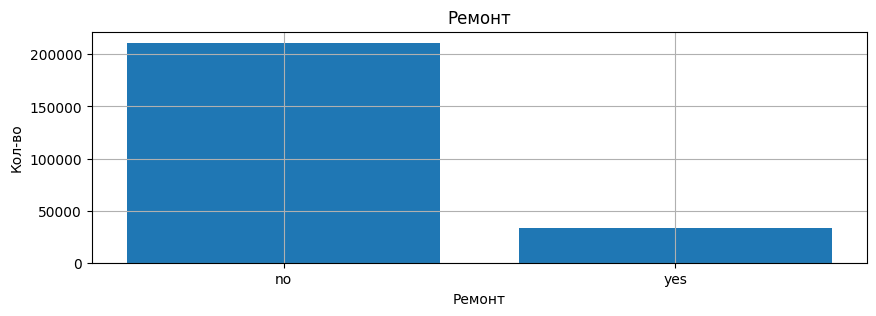

In [26]:
plot_analysis('repaired', 'Ремонт', (10, 3))


Изходя из отыла могу сделать вывод, что автомобилю техническое обслуживание лучше проходить каждые 15-20к км пробега (эти значения указывает производитель авто). Но образование мего говорит что запас прочности берётся с коэфициентом 0.8, значит примем 2000 за 80% ресурса работы авто, следоватетельно при значениях 25000 принемаем за 100%. При достежении этого значения приводет к повышенному износу и поломки узлов или агрегатов и начинается необратимые разрушения. Возьмём за основу данные значения и пометим все пропущенные значения основываясь на пробеге автомобиля.

In [27]:
data.loc[(data['kilometer'] >= 25000) & (data['repaired'].isna() == True), 'repaired'] = 'yes'
data.loc[(data['kilometer'] <= 25000) & (data['repaired'].isna() == True), 'repaired'] = 'no'

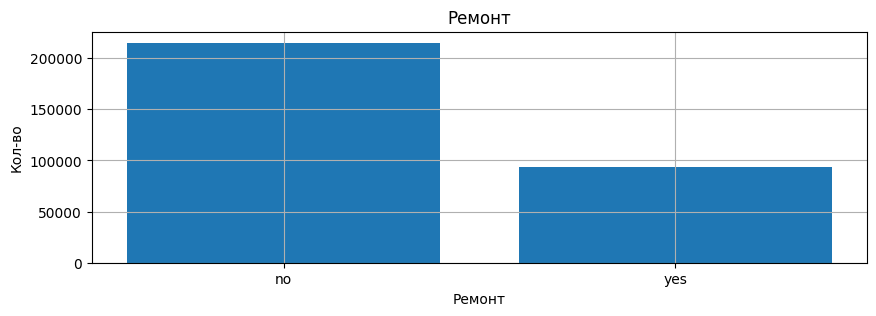

In [28]:
plot_analysis('repaired', 'Ремонт', (10, 3))

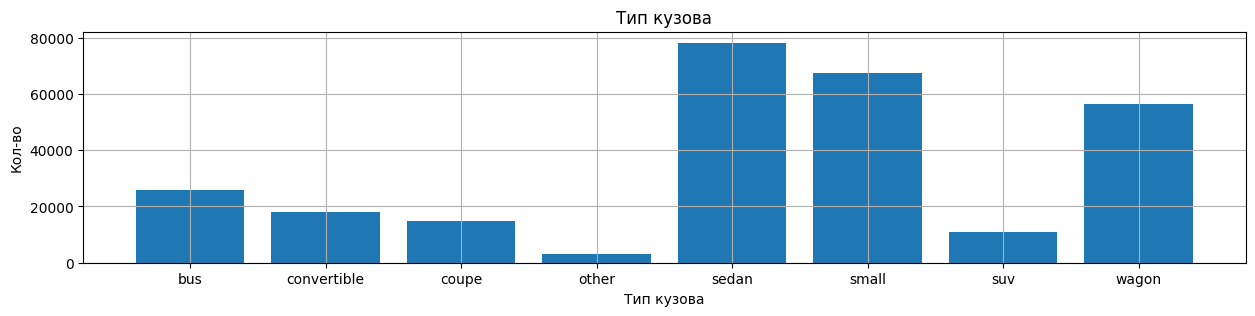

In [29]:
plot_analysis('vehicle', 'Тип кузова', (15, 3))

Больше всего продаются автомабили в кузове __универсал__, __седан__, __мини__, поэтому примем значения NuN за рандомное значение и из наиболее популятных автомобилей.

In [30]:
# общее кол-во пропусков
vehicle_null_count = data['vehicle'].isna().sum()

In [31]:
data.loc[data['vehicle'].isna() == True, 'vehicle'] = np.random.choice(['small', 'sedan', 'wagon'], size=vehicle_null_count)

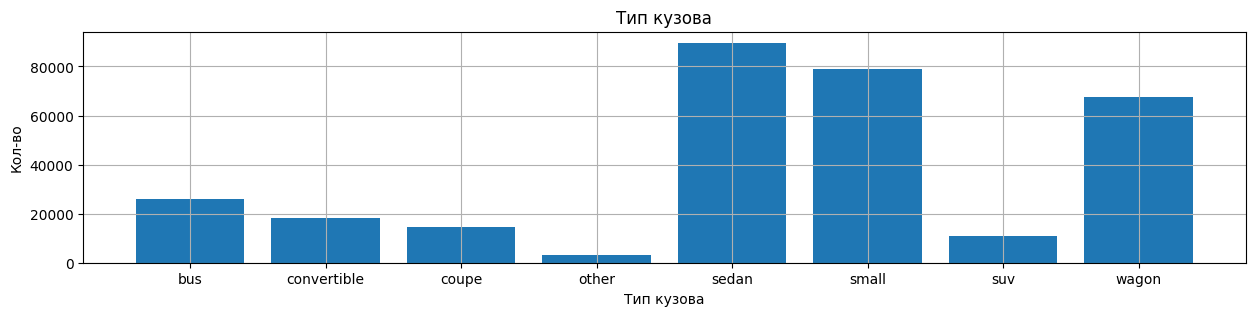

In [32]:
plot_analysis('vehicle', 'Тип кузова', (15, 3))

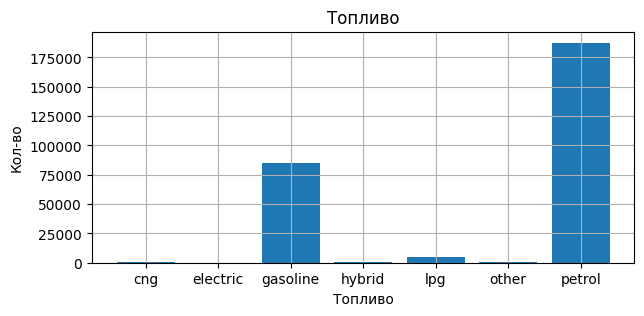

In [33]:
plot_analysis('fuel', 'Топливо', (7, 3))

В связи с тем что  __gasoline__ и __petrol__ это один тип топлива, считаю что их нужно объеденить в один группу, другие виды топлива необюходимо тоже обьеденить в категорию __other__. Хотя можно предположить что это может првести в лдолльнейшем к правблемам дизболанса и тогда вообще бедет проще удалить данную колонку.

In [34]:
data.loc[data['fuel'] == 'gasoline', 'fuel'] = 'petrol'

In [35]:
data.loc[(data['fuel'] == 'hybrid') | \
         (data['fuel'] == 'cng') | \
         (data['fuel'] == 'electric') | \
         (data['fuel'] == 'lpg'), 'fuel'] = 'other'

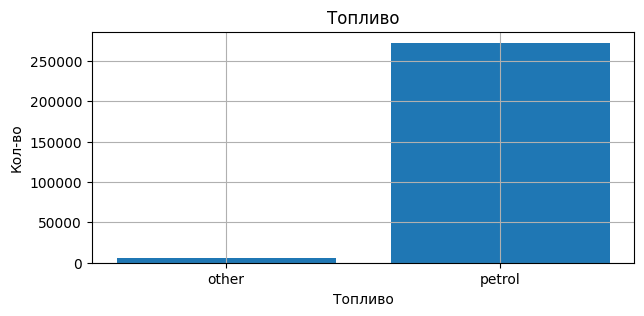

In [36]:
plot_analysis('fuel', 'Топливо', (7, 3))

Получилось два значения, заполненые NaN так же заполним рандомна как и предедущий раз.

In [37]:
# общее кол-во пропусков
fuel_null_count = data['fuel'].isna().sum()

In [38]:
data.loc[data['fuel'].isna() == True, 'fuel'] = np.random.choice(['other', 'petrol'], size=fuel_null_count)

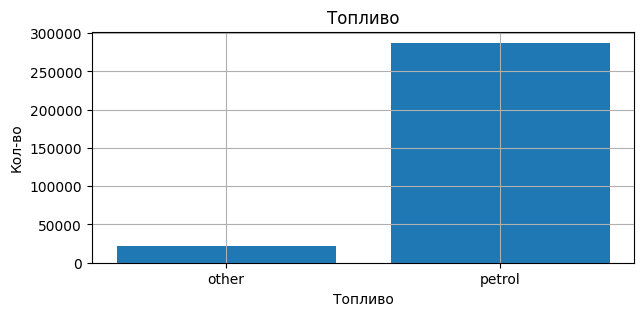

In [39]:
plot_analysis('fuel', 'Топливо', (7, 3))

### Исследовательский анализ

In [40]:
def box_hist(column, kind, ax):
    dis_title = {'kilometer':'Пробег', 'price':'Цена','registration_year':'Год регистрации','power':'Мощность'}
    dis_title_2 = {'vehicle':'Тип кузова', 'gearbox':'Коробка','model':'Модель','fuel':'Топливо', 'brand':'Марка', 'repaired':'Ремонт'}
    if kind == 'box':        
        sns.boxplot(data, y=column, ax=axis[ax]).set(title = dis_title[column]) 
    elif kind == 'hist':
        plt.xticks(rotation=90)
        sns.histplot(data = data[column], bins='auto', kde=False, multiple='dodge', ax=axis[ax]).set(title=dis_title_2[column])

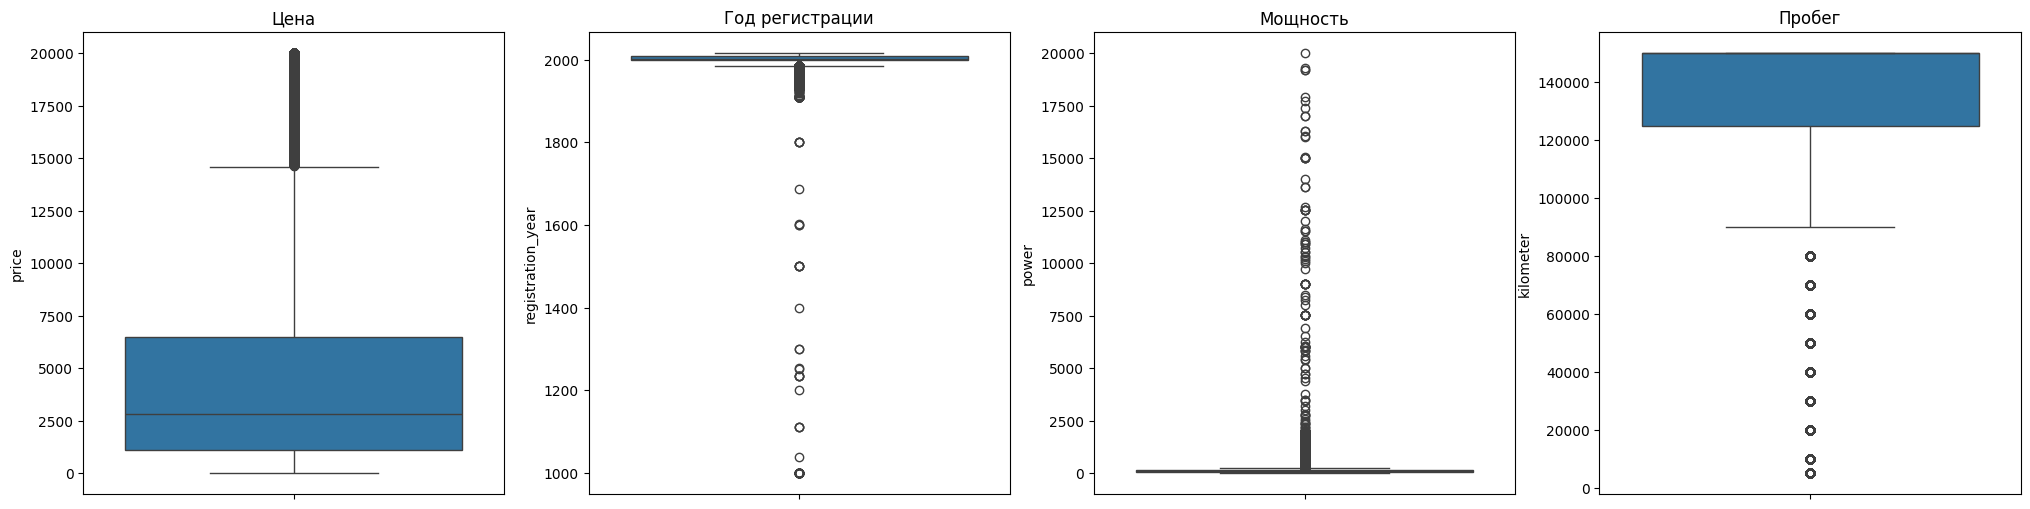

In [41]:
_, axis = plt.subplots(1, 4, figsize=(25, 6))
box_hist('price','box', 0)
box_hist('registration_year','box', 1)
box_hist('power','box', 2)
box_hist('kilometer','box', 3)

In [42]:
(data['registration_year']<1985).sum()

5186

Удаляем автомобили старше 1985 года

In [43]:
data = data.drop(data[data['registration_year']<1985].index, axis=0)

In [44]:
# Проверка на наличие регистрации автомобилей после даты выгрузки
data[data['registration_year']>2016]

,price,vehicle,registration_year,gearbox,power,model,kilometer,fuel,brand,repaired


Полазил по интернету и в том месте где я сейчас живу самый дешевый автомобиль стоит 270 у.е. на запчсати, поэтому мимимальную цену поднимаю до 300.

In [45]:
data = data.drop(data[data['price']<300].index, axis=0)

Разбераемся с мощьностью

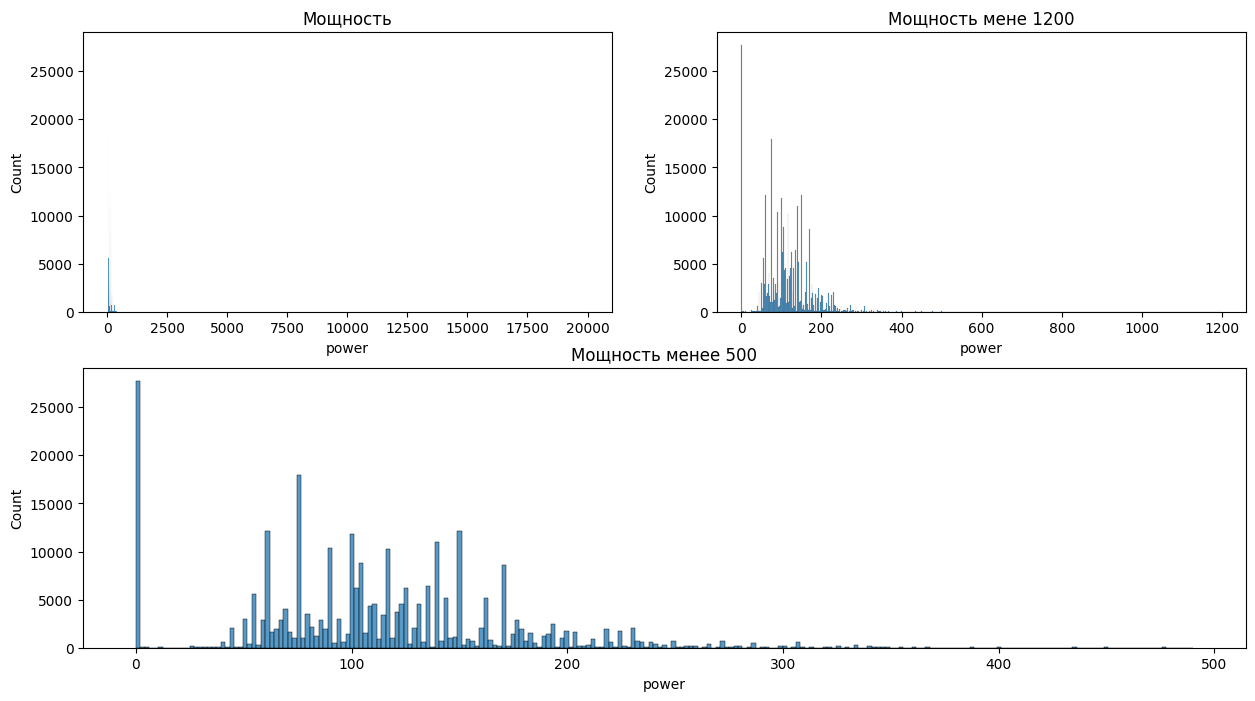

In [46]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(data =data['power']).set(title = 'Мощность')

plt.subplot(2, 2, 2)
sns.histplot(data[data['power']<1200]['power']).set(title ='Мощность мене 1200')

plt.subplot(2, 1, 2)
sns.histplot(data[data['power']<500]['power']).set(title = 'Мощность менее 500')
pass

Подвыляющее большенство автомобилей надожится в деапозоне значений от 0 до 350. Преворительный анализ показал что среди наименований позицей нет не одного поезда или акеанского лайнера поэтому мощность в 20000 можно смело игнорировать. Также покавырявшись погрубже обнаружел что большенство "выбросов" появились в результате не коректного введения данных, например smrt при всем желании не может обладать мощностью в 700 едениц как и порш, скорее всего один 0 лишней у смарта, а 70 уже реальная цифра. Но это требует длительного и неоправданно трудаемкого анализа и вычешениея данных. Поэтому проще не использовать данные больше 350.

In [47]:
data.query('power >= 350')['power'].count(), data.query('power <= 1')['power'].count()

(1056, 27714)

Нулевые значения приведем к модовым.

In [48]:
data.loc[data['power'] == 0, 'power'] = data['power'].mode()

In [49]:
#Удаляем все что больше 350
data = data.drop(data[(data['power'] >= 350)].index, axis=0)

In [50]:
# принемаем что самые маломощный автомобиль имеет 60 едениц
data.loc[data['power']<60,['power']]=60

In [51]:
#забиваем также средним значениями NaN
data.loc[data['power'].isna(), 'power']=data['power'].mean()

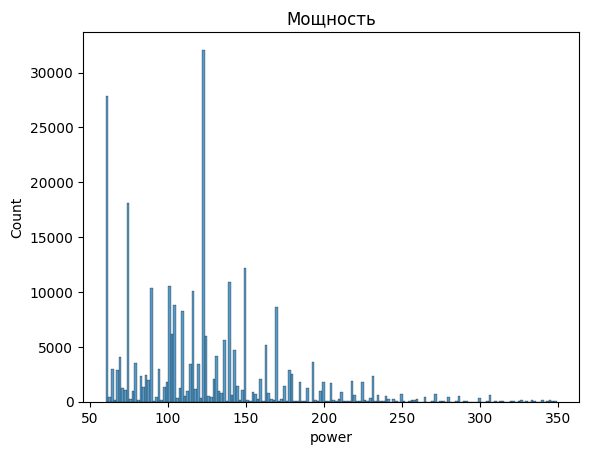

In [52]:
sns.histplot(data['power']).set(title = 'Мощность')
pass

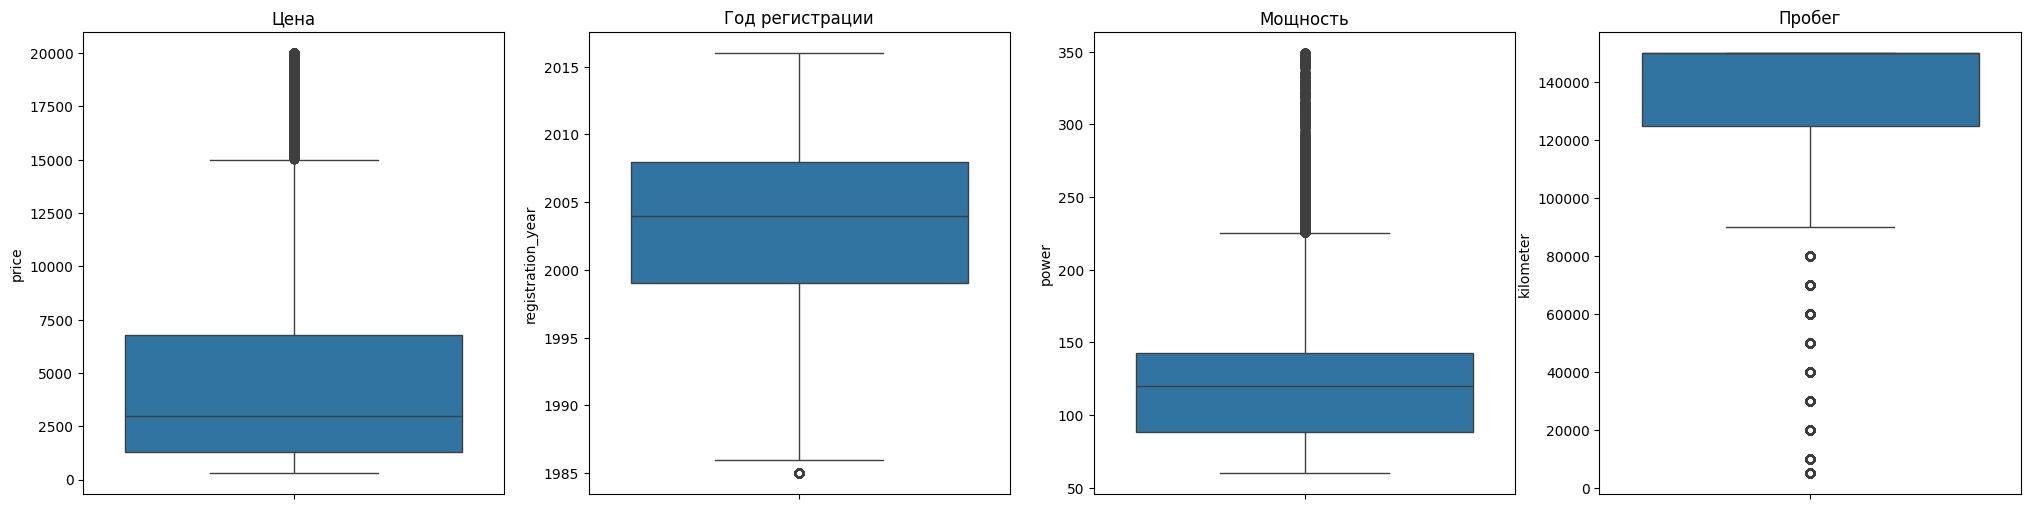

In [53]:
_, axis = plt.subplots(1, 4, figsize=(25, 6))
box_hist('price','box', 0)
box_hist('registration_year','box', 1)
box_hist('power','box', 2)
box_hist('kilometer','box', 3)

In [54]:
data.select_dtypes(include='object').columns.to_list()

['vehicle', 'gearbox', 'model', 'fuel', 'brand', 'repaired']

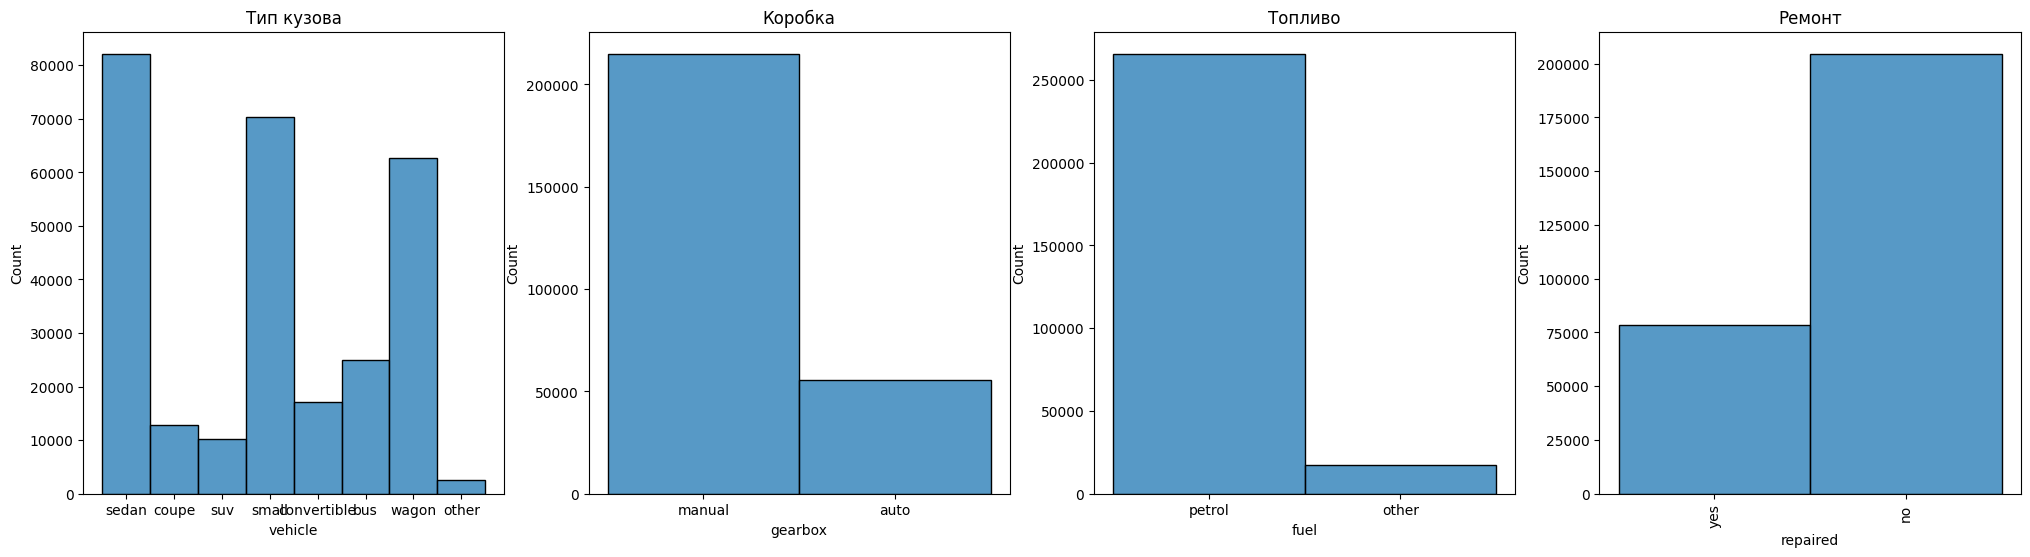

In [55]:
_, axis = plt.subplots(1, 4, figsize=(25, 6))
box_hist('vehicle','hist',0)
box_hist('gearbox','hist',1)
box_hist('fuel','hist',2)
box_hist('repaired','hist',3)

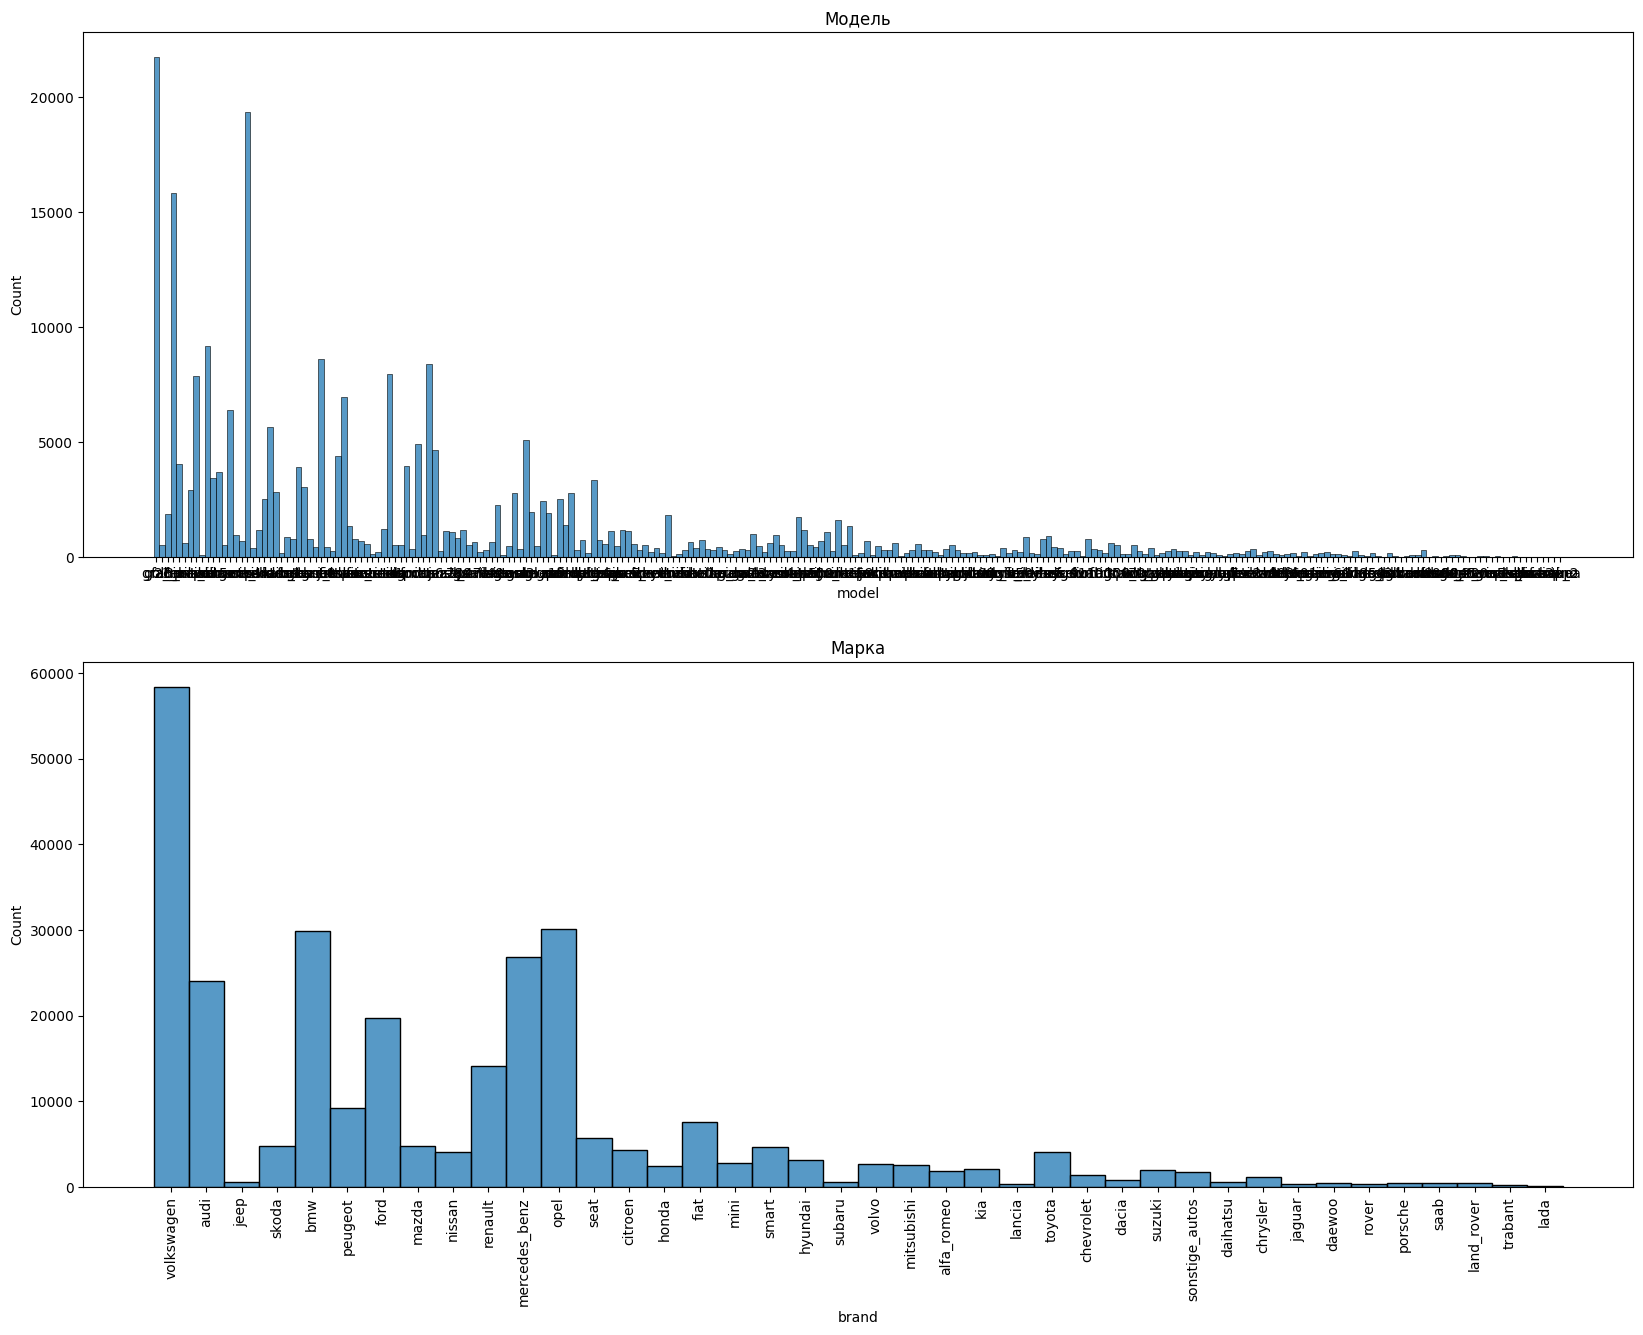

In [56]:
_, axis = plt.subplots(2, 1, figsize=(20, 15))
box_hist('model','hist', 0)
box_hist('brand','hist', 1)


In [57]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,282991.0,4747.729892,4527.981060,300.0,1300.5,3000.0,6800.0,20000.0
registration_year,282991.0,2003.796400,6.284100,1985.0,1999.0,2004.0,2008.0,2016.0
power,282991.0,122.234040,48.147760,60.0,88.0,120.0,143.0,349.0
kilometer,282991.0,127809.559315,37353.734947,5000.0,125000.0,150000.0,150000.0,150000.0


In [58]:
#почемуто "power" стал float
data['power']=data['power'].astype(int)

In [59]:
data.fillna('NaN', inplace=True)

## Обучение моделей

###  Подготовка данных к обучению

In [60]:
data.reset_index(drop=True, inplace=True)

In [61]:
def split_data(data, column_name):   
    X_train, X_test, y_train, y_test =\
    train_test_split(
            data.drop('price', axis=1),
            data['price'],
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE
    )
    return X_train, X_test, y_train, y_test

In [62]:
oec = OrdinalEncoder()
categorical_features = ['kilometer','registration_year', 'vehicle', 'gearbox', 'model', 'fuel', 'brand', 'repaired']
oec.fit(data[categorical_features])
data[categorical_features] = oec.transform(data[categorical_features])

In [63]:
X_train, X_test, y_train, y_test = split_data(data, 'price')

### Непосредственно само обучение

### Дерево

In [65]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [66]:
params = {
    'max_depth': [None] + [i for i in range(2, 7)],
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 5),
}

In [67]:
%%time
tree_grid = GridSearchCV(tree, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3)
tree_grid.fit(X_train, y_train)

CPU times: total: 3.27 s
Wall time: 9.09 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 4)},
             scoring='neg_root_mean_squared_error')

In [68]:
%%time
-1 * tree_grid.best_score_

CPU times: total: 0 ns
Wall time: 0 ns


1932.5302169800418

In [69]:
tree_grid_results = pd.DataFrame(tree_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [70]:
tree_fit = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_fit_time']
tree_pred = tree_grid_results.loc[tree_grid_results['rank_test_score'] == 1, 'mean_score_time']

### Catboost

In [71]:
%%time
catboost = CatBoostRegressor(thread_count=-1,
                             random_state=RANDOM_STATE,
                             learning_rate=0.1,
                             verbose=False)

CPU times: total: 0 ns
Wall time: 3.5 ms


In [72]:
params = {
    'n_estimators': range(1000, 2000, 500),
    'max_depth': range(1, 10, 4)
}

In [73]:
%%time
cat_grid = GridSearchCV(catboost, 
                        param_grid=params, 
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error',
                        error_score='raise',
                        cv=3)
cat_grid.fit(X_train, y_train)

CPU times: total: 21.7 s
Wall time: 2min 14s


GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x0000016534B9EB50>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10, 4),
                         'n_estimators': range(1000, 2000, 500)},
             scoring='neg_root_mean_squared_error')

In [74]:
%%time
-1 * cat_grid.best_score_

CPU times: total: 0 ns
Wall time: 0 ns


1625.288794036622

In [75]:
catboost_results = pd.DataFrame(cat_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [76]:
cat_fit = catboost_results.loc[catboost_results['rank_test_score'] == 1, 'mean_fit_time']
cat_pred = catboost_results.loc[catboost_results['rank_test_score'] == 1, 'mean_score_time']

### Light GBM

In [77]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [78]:
params = {
    'n_estimators': [1000, 2000,  500],
    'reg_lambda': np.arange(0.1, 0.3, 0.1),
}

In [79]:
%%time
lgbm_grid = GridSearchCV(lgbm, 
                         param_grid=params, 
                         n_jobs=-1, 
                         scoring='neg_root_mean_squared_error',
                         error_score='raise',cv=3)
lgbm_grid.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 212243, number of used features: 9
[LightGBM] [Info] Start training from score 4742.665841
CPU times: total: 26.2 s
Wall time: 45 s


GridSearchCV(cv=3, error_score='raise',
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [1000, 2000, 500],
                         'reg_lambda': array([0.1, 0.2])},
             scoring='neg_root_mean_squared_error')

In [80]:
%%time
-1 * lgbm_grid.best_score_

CPU times: total: 0 ns
Wall time: 0 ns


1617.9822177393955

In [81]:
lgbm_grid_results = pd.DataFrame(lgbm_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'rank_test_score']]

In [82]:
lgbm_fit = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_fit_time']
lgbm_pred = lgbm_grid_results.loc[lgbm_grid_results['rank_test_score'] == 1, 'mean_score_time']

 ТЗ гласит, что нужно выбрать модель __RMSE__-метрика которой будет превышать значение 2500. Для выполнения задания было проанализировано 3 модели: 1 из которых классическая и 2 - бустинги. Все модели справились с заданием самая быстрая оказалась класическая __Wall time: 9.17 s__, Самая точная  __Light GBM__  с временем __Wall time: 43.7 s__ и значением __rmse = 1614.15__.

## Анализ моделей

In [84]:
print(f'Tree fit time: {tree_fit.values[0]:.2f}, Tree predict time: {tree_pred.values[0]:.2f}')
print(f'LGBM fit time: {lgbm_fit.values[0]:.2f}, LGBM predict time: {lgbm_pred.values[0]:.2f}')
print(f'CatBoost fit time: {cat_fit.values[0]:.2f}, CatBoost predict time: {cat_pred.values[0]:.2f}\n')


print(f'Tree best score: {-1 * tree_grid.best_score_:.2f}')
print(f'LGBM best score: {-1 * lgbm_grid.best_score_:.2f}')
print(f'CatBoost best score: {-1 * cat_grid.best_score_:.2f}')

Tree fit time: 1.21, Tree predict time: 0.10
LGBM fit time: 31.05, LGBM predict time: 2.60
CatBoost fit time: 64.48, CatBoost predict time: 0.15

Tree best score: 1932.53
LGBM best score: 1617.98
CatBoost best score: 1625.29


Лучший результат на тестовой выборке показал Light GBM.

In [85]:
mean_squared_error(lgbm_grid.predict(X_test), y_test) ** 0.5

1612.9849507146248

__Проверка на адекватность__   
Сравним модели с простой, которая просто выбирает среднее значение

In [86]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_score = mean_squared_error(dummy_regr.predict(X_test), y_test)
dummy_score ** 0.5

4545.160847433101

Похоже, что обученные модели прошли проверку на адекватность

__Вывод__  
Для решения поставленной задачи была выполнена предобработка данных, исследовательский анализ и обучение различных моделей в кол-ве: 3 шт. Из классических моделей неплохо показало себя дерево решений, однако в ходе данной работы была выбрана наилучшая модель по скорости работы и точности получаемых значений - LightGBM regressor. Она привосходит "классические модели" по  параметрам: 1) Работает с категориальными признаками 2) Выше точность предсказания.